In [1]:
# This is boilerplate code to correctly setup the settings to for notebook.
import os, sys
for root, dirs, files in os.walk(os.getcwd()):
    # print(root)

    if "pi0-analysis" in root.split("/"):
        pypath = root.split("pi0-analysis")[0] + "/pi0-analysis/analysis"
        print(pypath)
        break

sys.path.insert(0, pypath)

from python.analysis.NotebookUtils import init_notebook
%init_notebook

/home/bhuller/new_python_test/xs_analysis//pi0-analysis/analysis
/home/bhuller/new_python_test/xs_analysis//pi0-analysis/analysis
env: PYTHONPATH=/home/bhuller/new_python_test/xs_analysis//pi0-analysis/analysis


In [20]:
from python.analysis import Master, Plots, BeamParticleSelection

In [ ]:
mc = Master.Data("/data/dune/common/PDSPAnalyzer_Ntuples/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03.root", nTuple_type=Master.Ntuple_Type.PDSP, target_momentum=2)
mask = BeamParticleSelection.BeamTriggerSelection(mc, use_beam_inst = False)
mc.Filter([mask], [mask])

In [31]:
data = Master.Data("/data/dune/common/PDSPAnalyzer_Ntuples/PDSPProd4_data_2GeV_reco2_ntuple_v09_42_03_01.root", nTuple_type = Master.Ntuple_Type.PDSP, target_momentum = 1)
mask = BeamParticleSelection.BeamTriggerSelection(data, use_beam_inst = True)
data.Filter([mask], [mask])

f=<Array [False, False, False, ..., False, False, False] type='1349399 * bool'>


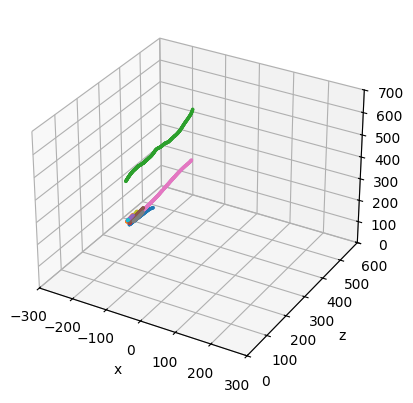

In [32]:
def plot_beam_tracks(events : Master.Data):
    fig = Plots.plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for i in range(10):
        ax.scatter(events.recoParticles.beam_calo_pos[i].x, events.recoParticles.beam_calo_pos[i].z, events.recoParticles.beam_calo_pos[i].y, s = 2)

    ax.set_xlim(-300, 300)
    ax.set_ylim(0, 600)
    ax.set_zlim(0, 700)
    ax.set_ylabel("z")
    ax.set_xlabel("x")
    ax.set_zlabel("y")
    return

plot_beam_tracks(data)

Text(0.5, 0, 'y')

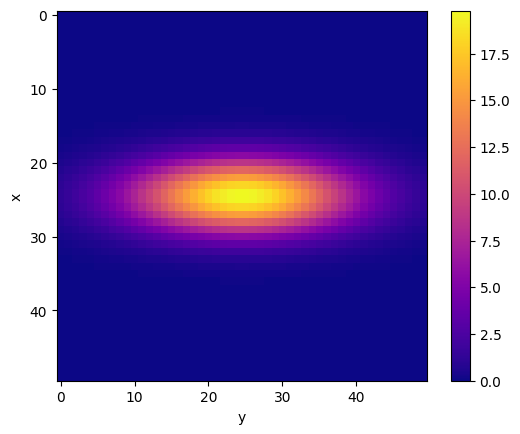

In [ ]:
import numpy as np

def gauss_2d(x, y, A = 1, mu_x = 0, sigma_x = 1, mu_y = 0, sigma_y = 1):
    return A * np.exp(-( ((x-mu_x)/sigma_x) **2 + ((y-mu_y)/sigma_y)**2))

x = np.linspace(-10, 10, 50)
y = np.linspace(-10, 10, 50)

mx, my = np.meshgrid(x, y, indexing = "xy")

sce_map = gauss_2d(mx, my, 20, 0, 6, 0, 2)

Plots.plt.imshow(sce_map, cmap = "plasma")
Plots.plt.colorbar()
Plots.plt.ylabel("x")
Plots.plt.xlabel("y")

In [80]:
point = [1, 5]
(mx == 1) & (my == 5)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(50, 50))